Rede neural CNN para a tarefa de classificação binária utilizando o extrator de dados HOG (Histogram of Oriented Gradients)

## Integrantes

- Elisa Yea Ji Lee - NUSP 11892473
- João Victor Andrade Lúcio - NUSP 11207877
- Leonardo Zoppello Fernandes - NUSP 13838749
- Marcos Paulo Tomás Ferreira - NUSP 13747950
- Rafael Moura de Almeida - NUSP 11225505
- Thomas Delfs - NUSP 13837175

Importar as bibliotecas e os dados do conjunto MNIST

In [1]:
import json

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from tensorflow.keras import layers
from skimage.feature import hog
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler

# 1. Carregar o conjunto de dados MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()


Criando a função que implementa o descritor HOG

In [2]:
def extract_hog_features(images):
    features = []
    for image in images:
        fd = hog(image, orientations=8, pixels_per_cell=(4, 4),cells_per_block=(1, 1), visualize=False)
        features.append(fd)
    return np.array(features)

Normalizar os dados. As imagens já vem em escala de cinza.

In [3]:
x_train = x_train / 255.0
x_test = x_test / 255.0

Extraír as características HOG do conjunto

In [4]:
x_train_hog = extract_hog_features(x_train)
x_test_hog = extract_hog_features(x_test)

Normalizando as características HOG extraídas

In [5]:
scaler = StandardScaler()
x_train_hog = scaler.fit_transform(x_train_hog)
x_test_hog = scaler.transform(x_test_hog)

Criar os filtros de classes

In [6]:
# Filtrar apenas duas classes (por exemplo, 0 e 1)
binary_classes = [0, 1]
train_filter = np.where((y_train == binary_classes[0]) | (y_train == binary_classes[1]))
test_filter = np.where((y_test == binary_classes[0]) | (y_test == binary_classes[1]))

Filtrar as classes

In [7]:
x_train_binary, y_train_binary = x_train_hog[train_filter], y_train[train_filter]
x_test_binary, y_test_binary = x_test_hog[test_filter], y_test[test_filter]

Converter os rótulos para one-hot encoding

`to_categorical(rótulos, número de classes)`

In [8]:
y_train_binary = to_categorical(y_train_binary, 2)
y_test_binary = to_categorical(y_test_binary, 2)

Construir o modelo

In [9]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(x_train_hog.shape[1],)),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dense(2, activation='sigmoid')
])

c:\Users\mtoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Compilar o modelo

In [10]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

- Criando e salvando os hiperparâmetros da arquitetura e da inicialização em formato json em arquivos-hog/hiperparametros.json

- Salvando os pesos iniciais

In [11]:
# Definir os hiperparâmetros
hiperparametros = {
    "architecture": {
        "input_shape": (28, 28, 1),
        "conv_layers": [
            {"filters": 32, "kernel_size": (3, 3), "activation": "relu"},
            {"filters": 64, "kernel_size": (3, 3), "activation": "relu"}
        ],
        "pooling_layers": [{"pool_size": (2, 2)}] * 2,
        "dropout_rates": [0.25, 0.25, 0.5],
        "dense_layers": [{"units": 128, "activation": "relu"}],
        "output_layer": {"units": 2, "activation": "softmax"}
    },
    "initialization": {
        "optimizer": "adam",
        "loss": "binary_crossentropy",
        "metrics": ["accuracy"]
    },
    "training": {
        "batch_size": 128,
        "epochs": 10,
        "validation_split": 0.1
    }
}

# Serializando os hiperparâmetros em uma string JSON
hiperparametros_json = json.dumps(hiperparametros, indent=4)

# Escrevendo a string JSON em um arquivo
with open("arquivos-hog/hiperparametros.json", "w") as arquivo:
    arquivo.write(hiperparametros_json)


# PESOS INICIAIS
model.save_weights('arquivos-hog/pesos_iniciais.weights.h5')

Treinar o modelo

In [12]:
historico = model.fit(x_train_binary, y_train_binary, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9629 - loss: 0.1002 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 2/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9982 - loss: 0.0053 - val_accuracy: 0.9996 - val_loss: 0.0014
Epoch 3/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9987 - loss: 0.0033 - val_accuracy: 0.9996 - val_loss: 0.0026
Epoch 4/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9993 - loss: 0.0020 - val_accuracy: 0.9996 - val_loss: 0.0023
Epoch 5/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9997 - loss: 0.0013 - val_accuracy: 0.9996 - val_loss: 0.0011
Epoch 6/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9998 - loss: 8.3117e-04 - val_accuracy: 0.9984 - val_loss: 0.0059
Epoch 7/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9996 - loss: 9.8555e-04 - val_accuracy: 0.9992 - val_loss: 8.1951e-04
Epoch 8/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9996 - loss: 0.0015 - val_

- Salvando os pesos finais da rede 
- Salvando o histórico de perda para cada iteração
- Salvando as saídas produzidas pela rede para cada um dos dados de teste

In [13]:
# PESOS FINAIS
model.save_weights('arquivos-hog/pesos_finais.weights.h5')

# ERRO DE CADA ITERAÇÃO
perdas = historico.history['loss']

# Salvando o histórico de perda em um arquivo JSON
with open('arquivos-hog/historico_perda.json', 'w') as f:
    json.dump(perdas, f)


# SAÍDAS PRODUZIDAS
# Fazendo inferência com o modelo treinado para obter as saídas
saidas = model.predict(x_test_binary)

# Convertendo as saídas para uma lista para serialização
saidas_lista = saidas.tolist()

# Salvando as saídas em um arquivo JSON
with open('arquivos-hog/saidas_teste.json', 'w') as f:
    json.dump(saidas_lista, f)

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Calculando a matriz de confusão

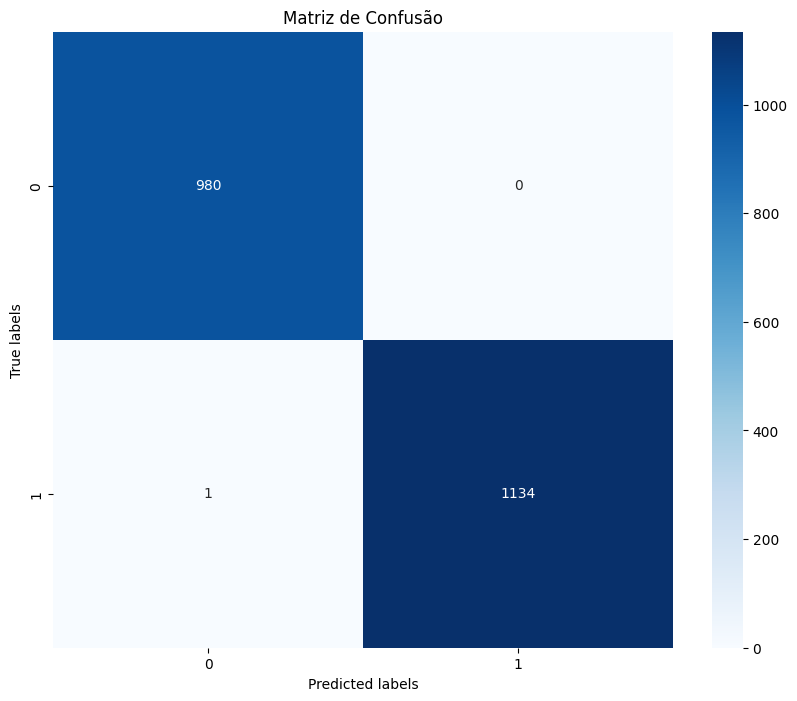

In [14]:
# Previsões
classes_previstas = np.argmax(saidas, axis=1)
classes_verdadeiras = np.argmax(y_test_binary, axis=1)

# Calcule a matriz de confusão
cm = confusion_matrix(classes_verdadeiras, classes_previstas)

# Plot a matriz de confusão
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Matriz de Confusão')
plt.show()

Testar o modelo

In [15]:
test_loss, test_acc = model.evaluate(x_test_binary, y_test_binary)
print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9999 - loss: 4.9802e-04
Test accuracy: 0.9995272159576416, Test loss: 0.0017071871552616358


NOTAS

O descritor HOG é uma técnica de extração de características usada para pré-processar imagens antes de alimentá-las a um modelo de aprendizado de máquina, que pode ser uma Rede Neural Densa, uma Máquina de Vetores de Suporte (SVM), entre outros, mas não é específico para simplificar ou modificar a arquitetura de uma CNN.

As CNNs são projetadas para aprender automaticamente hierarquias de características a partir dos dados brutos de entrada durante o treinamento. As camadas convolucionais e de pooling em uma CNN são capazes de extrair características importantes das imagens automaticamente, o que torna o uso de técnicas manuais de extração de características, como o HOG, geralmente desnecessário para este tipo de rede.

Portanto, a menção ao descritor HOG estava relacionada a uma abordagem alternativa de processamento de imagens para modelos que não são capazes de extração automática de características, e não como uma técnica para remover camadas de uma CNN.